In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

ner.csv
ner_dataset.csv




**Importing the dataset for named entity recognition model**

In [2]:
dframe = pd.read_csv("../input/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [3]:
dframe.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


**Data preprocessing**

In [4]:
dframe.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

* We want word, pos, sentence_idx and tag as an input 

In [5]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word'],axis=1)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 5 columns):
pos             1050794 non-null object
sentence_idx    1050794 non-null float64
shape           1050794 non-null object
word            1050794 non-null object
tag             1050794 non-null object
dtypes: float64(1), object(4)
memory usage: 40.1+ MB


In [7]:
dataset.head()

,pos,sentence_idx,shape,word,tag
0,NNS,1.0,capitalized,Thousands,O
1,IN,1.0,lowercase,of,O
2,NNS,1.0,lowercase,demonstrators,O
3,VBP,1.0,lowercase,have,O
4,VBN,1.0,lowercase,marched,O


In [8]:
dataset=dataset.drop(['shape'],axis=1)

In [9]:
dataset.head()

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O


> **Create list of list of tuples to differentiate each sentence from each other**

In [10]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w,p, t) for w,p, t in zip(s["word"].values.tolist(),
                                                       s['pos'].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(dataset)

In [12]:
sentences = getter.sentences

In [13]:
print(sentences[0:1])

[[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O'), ('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops'

In [14]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [15]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

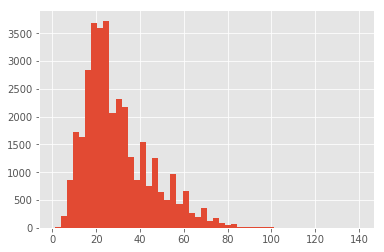

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [17]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [18]:
n_words = len(words); n_words

30174

In [19]:
tags = list(set(dataset["tag"].values))

In [20]:
n_tags = len(tags); n_tags

18

**Converting words to numbers and numbers to words**

In [21]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [22]:
word2idx['Obama']

17903

In [23]:
tag2idx['B-geo']

7

In [38]:
tag2idx

{nan: 0,
 'O': 1,
 'I-eve': 2,
 'I-gpe': 3,
 'B-eve': 4,
 'I-nat': 5,
 'B-nat': 6,
 'B-geo': 7,
 'I-org': 8,
 'B-per': 9,
 'I-geo': 10,
 'I-tim': 11,
 'B-org': 12,
 'I-per': 13,
 'I-art': 14,
 'B-gpe': 15,
 'B-tim': 16,
 'B-art': 17}

In [24]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [25]:
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)

In [26]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [27]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [28]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
max([len(tr) for tr in X_train]), len(X_train)

(140, 28141)

In [37]:
max([len(tr) for tr in y_train]), len(y_train)

(140, 28141)

In [30]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [31]:
input = Input(shape=(140,))
model = Embedding(input_dim=n_words, output_dim=100, input_length=140)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [32]:
model = Model(input, out)

In [33]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [34]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

Train on 22512 samples, validate on 5629 samples
Epoch 1/1
22512/22512 [==============================] - 492s 22ms/step - loss: 0.1332 - acc: 0.9743 - val_loss: 0.0472 - val_acc: 0.9870


In [35]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(words[w],tags[pred]))

Word            (True ): Pred
Nuclear        : B-org
envoys         : O
from           : O
North          : B-geo
and            : O
South          : B-geo
Korea          : I-geo
have           : O
met            : O
in             : O
Beijing        : B-geo
as             : O
part           : O
of             : O
attempts       : O
to             : O
resume         : O
six-party      : O
talks          : O
on             : O
Pyongyang      : B-geo
's             : O
nuclear        : O
weapons        : O
program        : O
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         

In [39]:
p[0]

array([12,  1,  1,  7,  1,  7, 10,  1,  1,  1,  7,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [43]:
import re
class NERInference:
    def __init__(self, model, words, word2idx, tags, n_words, maxlen=140, split_pattern="(,|!|\.| +)"):
        self.model = model
        self.words = words
        self.word2idx = word2idx
        self.tags = tags
        self.n_words = n_words
        self.pattern = split_pattern
        self.maxlen = maxlen
        
    def predict(self, string):
        tokens = [[self.word2idx[word] for word in re.split(self.pattern, string) if word in self.words]]
        padded = pad_sequences(tokens, maxlen=self.maxlen, padding='post', value=n_words-1)
        pred_ner = np.argmax(self.model.predict(padded), axis=-1)
        for w,pred in zip(padded[0], pred_ner[0]):
            if w == self.n_words - 1:
                break
            print("{:15}: {}".format(self.words[w], self.tags[pred]))
        

In [44]:
myNerInfer = NERInference(model, word2idx=word2idx, words=words, tags=tags, n_words=n_words, maxlen=140)

In [45]:
new_string = "I love Beijing, it is a beautiful city! I love living there. And my friend Mike Brown is from Beijing."
myNerInfer.predict(string=new_string)

I              : O
love           : O
Beijing        : B-geo
,              : O
it             : O
is             : O
a              : O
beautiful      : O
city           : O
!              : O
I              : O
love           : O
living         : O
there          : O
.              : O
And            : O
my             : O
friend         : O
Mike           : B-per
Brown          : I-geo
is             : O
from           : O
Beijing        : B-geo
.              : O
